# Урок 6. Градиентный бустинг (AdaBoost)

Задание 1: Для реализованной в методичке модели градиентного бустинга построить графики зависимости ошибки от количества деревьев в ансамбле и от максимальной глубины деревьев. Сделать выводы о зависимости ошибки от этих параметров.  
  
Задание 2: (опция) . Модифицировать реализованный алгоритм, чтобы получился стохастический градиентный бустинг. Размер подвыборки принять равным 0.5. Сравнить на одном графике кривые изменения ошибки на тестовой выборке в зависимости от числа итераций.  
  
Задание 3:(опция). Реализовать алгоритм градиетного бустинга, основанный на реализации решающего дерева из ДЗ4 / методички к уроку 4. Сделать выводы о качестве алгоритма по сравнению с реализацией из п.1.

In [1]:
from sklearn.tree import DecisionTreeRegressor

from sklearn import model_selection
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

In [2]:
from sklearn.datasets import load_diabetes

In [3]:
X, y = load_diabetes(return_X_y=True)

In [4]:
df = pd.DataFrame(X)
df['y'] = y
df.head()

,0,1,2,3,4,5,6,7,8,9,y
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019908,-0.017646,151.0
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068330,-0.092204,75.0
2,0.085299,0.050680,0.044451,-0.005671,-0.045599,-0.034194,-0.032356,-0.002592,0.002864,-0.025930,141.0
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022692,-0.009362,206.0
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031991,-0.046641,135.0


In [5]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25)

### Заменил в gb_predict() лишний генератор листа на нампаемскую сумму по строкам. Теперь весь алгоритм отрабатывает намного быстрее

In [6]:
def gb_predict(X, trees_list, coef_list, eta):
    # Реализуемый алгоритм градиентного бустинга будет инициализироваться нулевыми значениями,
    # поэтому все деревья из списка trees_list уже являются дополнительными и при предсказании прибавляются с шагом eta
    predictions = np.sum([eta * coef * alg.predict(X) for alg, coef in zip(trees_list, coef_list)], axis=0)
    return predictions

In [7]:
def mean_squared_error(y_real, prediction):
    return (sum((y_real - prediction)**2)) / len(y_real)

In [8]:
def bias(y, z):
    return (y - z)

Тут убрал дублирование кода в if/else

In [9]:
def gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta):
    
    # Деревья будем записывать в список
    trees = []
    
    # Будем записывать ошибки на обучающей и тестовой выборке на каждой итерации в список
    train_errors = []
    test_errors = []
    
    for i in range(n_trees):
        tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)

        # инициализируем бустинг начальным алгоритмом, возвращающим ноль, 
        # поэтому первый алгоритм просто обучаем на выборке и добавляем в список
        if len(trees) == 0:
            # обучаем первое дерево на обучающей выборке
            tree.fit(X_train, y_train)
        else:
            # Получим ответы на текущей композиции
            target = gb_predict(X_train, trees, coefs, eta)
            
            # алгоритмы начиная со второго обучаем на сдвиг
            tree.fit(X_train, bias(y_train, target))
            
        train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
        test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))

        trees.append(tree)
        
    return trees, train_errors, test_errors

## Задание 1: Построить графики зависимости ошибки от количества деревьев в ансамбле и от максимальной глубины деревьев. 
Сделать выводы о зависимости ошибки от этих параметров.

In [10]:
def eval_plt(errs_dict, target):
    plt.figure(figsize=(10, 5))
    plt.plot(errs_dict[f'{target}'], errs_dict['train_mse'])
    plt.plot(errs_dict[f'{target}'], errs_dict['test_mse'])
    plt.title(f'Dependence of MSE on {target}')
    plt.xlabel(f'{target}')
    plt.ylabel('MSE')
    plt.show()

In [11]:
def diff_plt(errs_dict, target):
    diff = []
    for i in range(len(errs_dict['test_mse'])):
        diff.append(errs_dict['test_mse'][i] - errs_dict['train_mse'][i])

    plt.figure(figsize=(10, 5))
    plt.plot(errs_dict[target], diff)
    plt.title('Difference between train_MSE and test_MSE')
    plt.xlabel(f'{target}')
    plt.ylabel('diff')
    plt.show()

Решил начать подбор гиперпараметров со скорости обучения, а не с кол-ва деревьев. Иначе лучшее кол-во деревьев будет минимальным

In [12]:
n_trees = 30
coefs = [1] * n_trees
max_depth = 2

eta_list = [el for el in np.arange(1e-2, 10.1e-1, 1e-2)]
target = 'eta'
errs_dict = {f'{target}': [], 'train_mse': [], 'test_mse': []}

for el in eta_list:
    trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, el)
    errs_dict['train_mse'].append(train_errors[-1])
    errs_dict['test_mse'].append(test_errors[-1])
    errs_dict[f'{target}'].append(el)

idx = np.argmin(errs_dict['test_mse'])
print(f'Best test_mse: {errs_dict["test_mse"][idx]}. Best {target}: {errs_dict[target][idx]}')

Best test_mse: 3355.549378647232. Best eta: 0.19


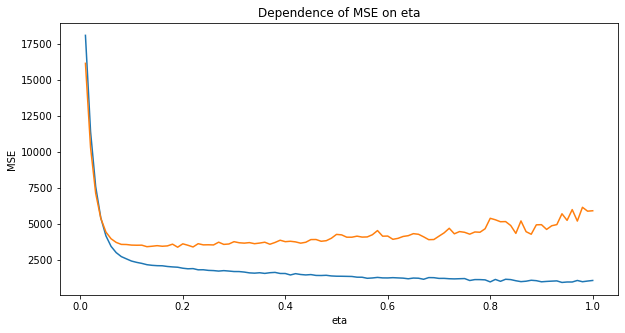

In [13]:
eval_plt(errs_dict, f'{target}')

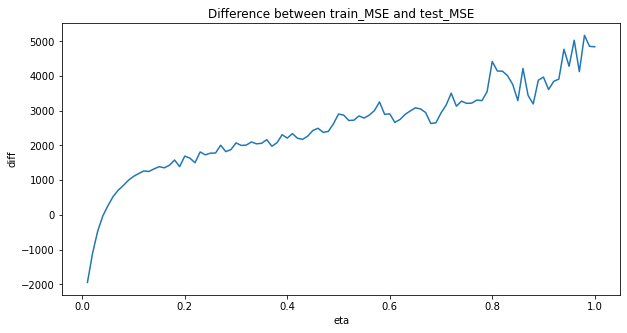

In [14]:
diff_plt(errs_dict, target)

***
Видим, что с увеличением скорости обучения алгоритм сильнее расходится (ошибка на трейне уменьшается, на тесте увеличивается)  
  
Лучшее значение - 0.19 (test_mse = 3355.5493)  

Теперь подбираем лучшую глубину деревьев
***

In [18]:
n_trees = 30
coefs = [1] * n_trees
eta = 0.19

depth_list = [el for el in range(1, 20)]
target = 'max_depth'
errs_dict = {f'{target}': [], 'train_mse': [], 'test_mse': []}

for el in depth_list:
    trees, train_errors, test_errors = gb_fit(n_trees, el, X_train, X_test, y_train, y_test, coefs, eta)
    errs_dict['train_mse'].append(train_errors[-1])
    errs_dict['test_mse'].append(test_errors[-1])
    errs_dict[f'{target}'].append(el)

idx = np.argmin(errs_dict['test_mse'])
print(f'Best test_mse: {errs_dict["test_mse"][idx]}. Best max_depth: {errs_dict[f"{target}"][idx]}')

Best test_mse: 3264.8500845636036. Best max_depth: 1


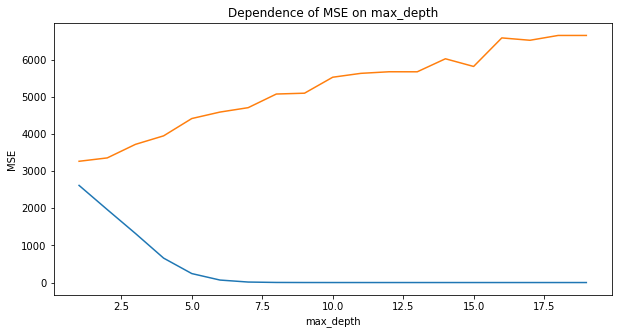

In [19]:
eval_plt(errs_dict, 'max_depth')

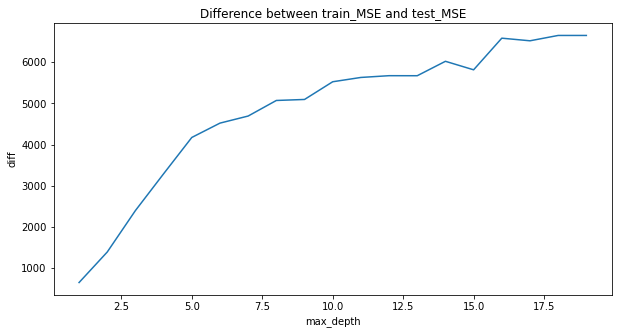

In [20]:
diff_plt(errs_dict, target)

***
Максимальная глубина очень сильно влияет на переобучение модели, так как деревья решений сами по себе очень склонны к переобучению  
  
Чем меньше "обрезать" деревья, тем больше модель будет переобучена  
  
В нашем случае, хватает глубины 2, дальше алгоритм сильно расходится (пеньки с единичной глубиной - увеличивают MSE)
  
Теперь подбираем лучшее кол-во деревьев
***

In [24]:
max_depth = 2
eta = 0.19
n_trees = 40

trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)
idx = np.argmin(test_errors)
print(f'Best test_mse: {test_errors[idx]}. Best number of trees: {idx + 1}')

Best test_mse: 3355.549378647232. Best number of trees: 30


<function matplotlib.pyplot.show(close=None, block=None)>

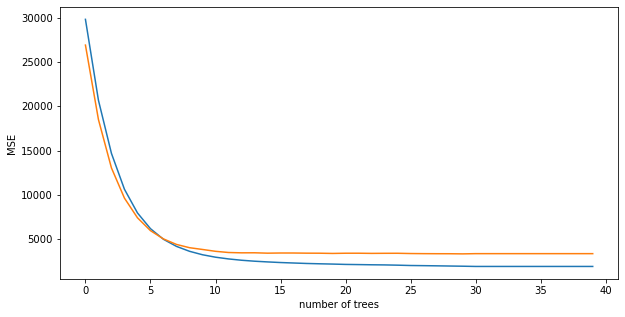

In [22]:
plt.figure(figsize=(10, 5))
plt.plot(range(len(trees)), train_errors)
plt.plot(range(len(trees)), test_errors)
plt.xlabel('number of trees')
plt.ylabel('MSE')
plt.show

***
Лучшим кол-вом деревьев при нашей скорости является +-30
  
Лучшее MSE на тесте - 3355.5493
  
Строим алгоритм по подобранным параметрам и выводим, "приближенный к финальным ошибкам", график
***

In [25]:
%%time
max_depth = 2
eta = 0.19
n_trees = 30

trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)
idx = np.argmin(test_errors)
print(f'Best test_mse: {test_errors[idx]}')

Best test_mse: 3355.549378647232
Wall time: 128 ms


<function matplotlib.pyplot.show(close=None, block=None)>

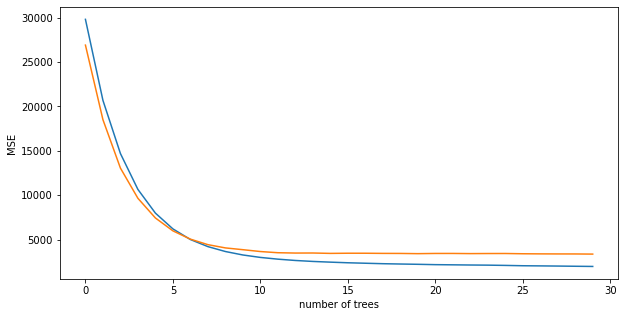

In [26]:
plt.figure(figsize=(10, 5))
plt.plot(range(len(trees)), train_errors)
plt.plot(range(len(trees)), test_errors)
plt.xlabel('number of trees')
plt.ylabel('MSE')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

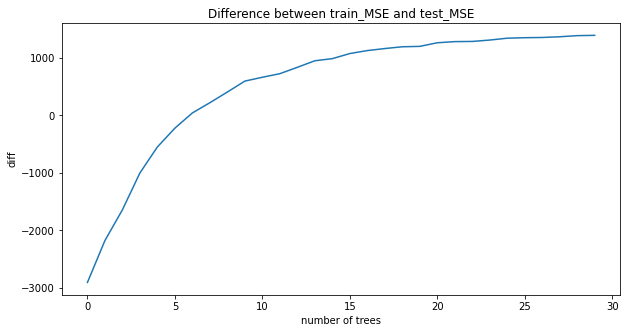

In [27]:
diff = []
for i in range(len(test_errors)):
    diff.append(test_errors[i] - train_errors[i])
    
plt.figure(figsize=(10, 5))
plt.plot(range(len(test_errors)), diff)
plt.title('Difference between train_MSE and test_MSE')
plt.xlabel('number of trees')
plt.ylabel('diff')
plt.show

***
**Итоги градиентного бустинга:**
- Лучшее test_mse - 3355.5493
- Время работы алгоритма - 128 ms
- Разница между train/test - 1050  
  
При лучшем тестовом мсе 3000, у нас разница с трейном 1000, это примерно 30%, что можно считать переобучением  
  
Однако я провел все выборы гипермараметров еще раз, обращая внимание на переобучение и в итоге получилось только увеличить MSE, а разница между трейном и тестом так и осталась равна +-1000  
  
Поэтому списываем это на истинный разброс данных
***

## Задание 2: (опция) . Модифицировать реализованный алгоритм, чтобы получился стохастический градиентный бустинг. Размер подвыборки принять равным 0.5. Сравнить на одном графике кривые изменения ошибки на тестовой выборке в зависимости от числа итераций.

In [28]:
def get_batch(X, y, size):
    n = X.shape[0]
    indexes = np.random.choice(n, round(n * size), replace=False)
    return X[indexes], y[indexes]

In [29]:
def s_gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta, batch_size):
    
    # Деревья будем записывать в список
    trees = []
    
    # Будем записывать ошибки на обучающей и тестовой выборке на каждой итерации в список
    train_errors = []
    test_errors = []
    
    for i in range(n_trees):
        tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)
        X_batch, y_batch = get_batch(X_train, y_train, batch_size)
        # инициализируем бустинг начальным алгоритмом, возвращающим ноль, 
        # поэтому первый алгоритм просто обучаем на выборке и добавляем в список
        if len(trees) == 0:
            # обучаем первое дерево на обучающей выборке
            tree.fit(X_batch, y_batch)
        else:
            # Получим ответы на текущей композиции
            target = gb_predict(X_batch, trees, coefs, eta)
            
            # алгоритмы начиная со второго обучаем на сдвиг
            tree.fit(X_batch, bias(y_batch, target))
            
        train_errors.append(mean_squared_error(y_batch, gb_predict(X_batch, trees, coefs, eta)))
        test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))

        trees.append(tree)
        
    return trees, train_errors, test_errors

***
Подбираем параметры для стохастического градиентного бустинга

Скорость обучения:
***

In [30]:
n_trees = 30
coefs = [1] * n_trees
max_depth = 3
batch_size = 0.5

eta_list = [el for el in np.arange(1e-2, 10.1e-1, 1e-2)]
target = 'eta'
errs_dict = {f'{target}': [], 'train_mse': [], 'test_mse': []}

for el in eta_list:
    trees, train_errors, test_errors = s_gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, el, batch_size)
    errs_dict['train_mse'].append(train_errors[-1])
    errs_dict['test_mse'].append(test_errors[-1])
    errs_dict[f'{target}'].append(el)

idx = np.argmin(errs_dict['test_mse'])
print(f'Best test_mse: {errs_dict["test_mse"][idx]}. Best {target}: {errs_dict[target][idx]}')

Best test_mse: 3234.499257897297. Best eta: 0.12


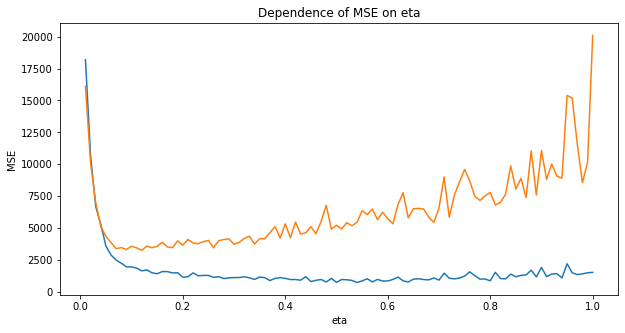

In [31]:
eval_plt(errs_dict, f'{target}')

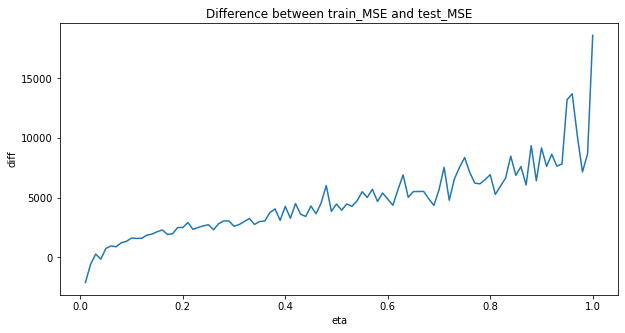

In [32]:
diff_plt(errs_dict, target)

***
Оптимальная скорость обучения - 0.12  
  
Максимальная глубина деревьев:  
***

In [33]:
n_trees = 30
coefs = [1] * n_trees
eta = 0.12
batch_size = 0.5

depth_list = [el for el in range(1, 20)]
target = 'max_depth'
errs_dict = {f'{target}': [], 'train_mse': [], 'test_mse': []}

for el in depth_list:
    trees, train_errors, test_errors = s_gb_fit(n_trees, el, X_train, X_test, y_train, y_test, coefs, eta, batch_size)
    errs_dict['train_mse'].append(train_errors[-1])
    errs_dict['test_mse'].append(test_errors[-1])
    errs_dict[f'{target}'].append(el)

idx = np.argmin(errs_dict['test_mse'])
print(f'Best test_mse: {errs_dict["test_mse"][idx]}. Best max_depth: {errs_dict[f"{target}"][idx]}')

Best test_mse: 3154.239148616982. Best max_depth: 1


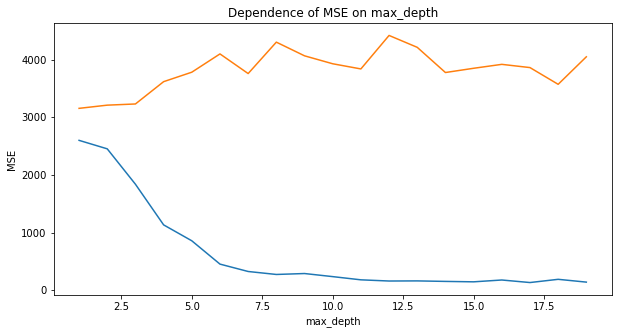

In [34]:
eval_plt(errs_dict, f'{target}')

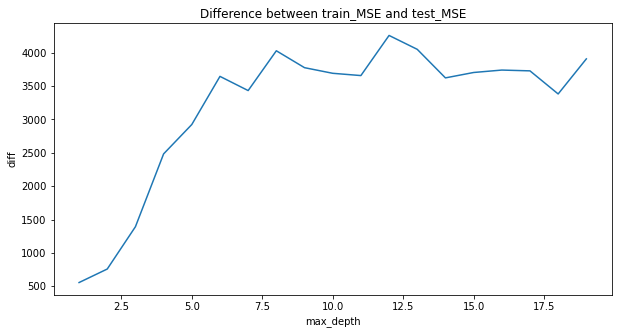

In [35]:
diff_plt(errs_dict, target)

***
Лучше всего себя показали пеньки (максимальная глубина 1)  
  
Кол-во деревьев (итераций бустинга):
***

In [36]:
%%time
max_depth = 2
eta = 0.12
n_trees = 40
batch_size = 0.5

trees, train_errors, test_errors = s_gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta, batch_size)
idx = np.argmin(test_errors)
print(f'Best test_mse: {test_errors[idx]}. Best number of trees: {idx + 1}')

Best test_mse: 3342.5072280004956. Best number of trees: 23
Wall time: 190 ms


<function matplotlib.pyplot.show(close=None, block=None)>

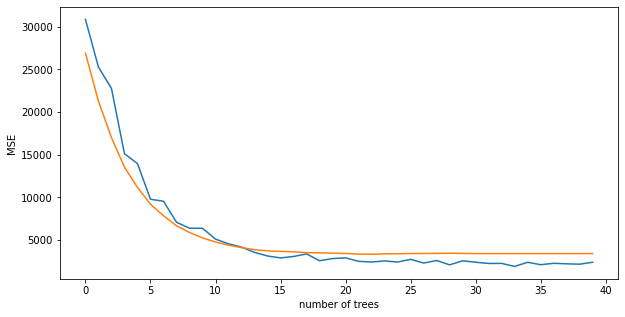

In [37]:
plt.figure(figsize=(10, 5))
plt.plot(range(len(trees)), train_errors)
plt.plot(range(len(trees)), test_errors)
plt.xlabel('number of trees')
plt.ylabel('MSE')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

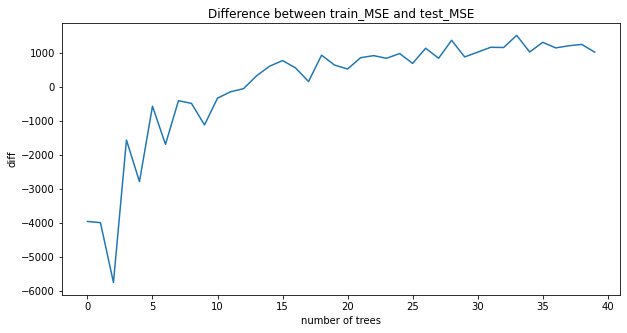

In [38]:
diff = []
for i in range(len(test_errors)):
    diff.append(test_errors[i] - train_errors[i])
    
plt.figure(figsize=(10, 5))
plt.plot(range(len(test_errors)), diff)
plt.title('Difference between train_MSE and test_MSE')
plt.xlabel('number of trees')
plt.ylabel('diff')
plt.show

***
**Итоги стохастического градиентного бустинга:**
- Лучшее test_mse - 3342.5072
- Время работы алгоритма - 190 ms
- Разница между train/test - 800  
  
**Выводы:**  
  
Разница между трейном и тестом у нас +- такая же, как и у обычного бустинга  
Итоговая тестовая MSE примерно тоже  
По скорости алгоритм отработал столько же времени
  
Заметно, что не смотря на рандомизацию выборки и скачащие значения ошибки на трейне, график number_of_trees/test_mse выглядит очень гладко
***

## Задание 3:(опция). Реализовать алгоритм градиетного бустинга, основанный на реализации решающего дерева из ДЗ4 / методички к уроку 4. Сделать выводы о качестве алгоритма по сравнению с реализацией из п.1.

Дерево решений из урока 4:

In [39]:
class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [40]:
class Leaf_Reg:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        
    def predict(self):
        return np.mean(self.labels)

In [41]:
def _variance(labels):        
    return np.var(labels)

In [42]:
# Расчет качества

def quality(left_labels, right_labels, current_impurity, impurity_func: callable):

    # доля выбоки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    return current_impurity - p * impurity_func(left_labels) - (1 - p) * impurity_func(right_labels)

In [43]:
# Разбиение датасета в узле

def split(data, labels, index, t):
    
    left = np.where(data[:, index] <= t)
    right = np.where(data[:, index] > t)
        
    true_data = data[left]
    false_data = data[right]
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels

In [44]:
# Нахождение наилучшего разбиения

def find_best_split(data, labels, impurity_func: callable, min_leaf: int = 5):
    
    current_impurity = impurity_func(labels)

    best_quality = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    for index in range(n_features):
        # будем проверять только уникальные значения признака, исключая повторения
        t_values = np.unique([row[index] for row in data])
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
            if len(true_data) < min_leaf or len(false_data) < min_leaf:
                continue
            
            current_quality = quality(true_labels, false_labels, current_impurity, impurity_func=impurity_func)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index

In [45]:
def build_tree_reg(data, labels, impurity_func: callable, min_leaf: int = 5, depth_lim: int = np.inf, depth_i=1):
    
    quality, t, index = find_best_split(data, labels, min_leaf=min_leaf, impurity_func=impurity_func)

    if quality == 0 or depth_i > depth_lim:
        return Leaf_Reg(data, labels) # вот тут заменяем класс листа на новый

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    depth_i += 1
    true_branch = build_tree_reg(true_data, true_labels, impurity_func, min_leaf=min_leaf, depth_lim=depth_lim, depth_i=depth_i)
    false_branch = build_tree_reg(false_data, false_labels, impurity_func, min_leaf=min_leaf, depth_lim=depth_lim, depth_i=depth_i)

    return Node(index, t, true_branch, false_branch)

In [46]:
def calc_mse(y, y_pred):
    return np.mean((y - y_pred)**2)

In [47]:
def predict_value(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf_Reg):
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return predict_value(obj, node.true_branch)
    else:
        return predict_value(obj, node.false_branch)

In [48]:
def predict_reg(data, tree):
    
    classes = []
    for obj in data:
        prediction = predict_value(obj, tree)
        classes.append(prediction)
    classes = np.array(classes)
    return classes

#### Заменил DecisionTreeRegressor на build_tree_reg()

In [49]:
def gb_fit_custom(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta):
    
    # Деревья будем записывать в список
    trees = []
    
    # Будем записывать ошибки на обучающей и тестовой выборке на каждой итерации в список
    train_errors = []
    test_errors = []
    
    for i in range(n_trees):
        # инициализируем бустинг начальным алгоритмом, возвращающим ноль, 
        # поэтому первый алгоритм просто обучаем на выборке и добавляем в список
        if len(trees) == 0:
            # обучаем первое дерево на обучающей выборке
            tree = build_tree_reg(X_train, y_train, _variance, depth_lim=max_depth)
        else:
            # Получим ответы на текущей композиции
            target = gb_predict_custom(X_train, trees, coefs, eta)
            
            # алгоритмы начиная со второго обучаем на сдвиг
            tree = build_tree_reg(X_train, bias(y_train, target), _variance, depth_lim=max_depth)
            
        train_errors.append(mean_squared_error(y_train, gb_predict_custom(X_train, trees, coefs, eta)))
        test_errors.append(mean_squared_error(y_test, gb_predict_custom(X_test, trees, coefs, eta)))

        trees.append(tree)
        
    return trees, train_errors, test_errors

#### Заменил alg.predict(X) на предикт функцию для деревьев из 4 урока

In [50]:
def gb_predict_custom(X, trees_list, coef_list, eta):
    # Реализуемый алгоритм градиентного бустинга будет инициализироваться нулевыми значениями,
    # поэтому все деревья из списка trees_list уже являются дополнительными и при предсказании прибавляются с шагом eta
    predictions = np.sum([eta * coef * predict_reg(X, alg) for alg, coef in zip(trees_list, coef_list)], axis=0)
    return predictions

***
Строим бустинг
***

In [51]:
%%time
max_depth = 2
eta = 0.19
n_trees = 35

trees, train_errors, test_errors = gb_fit_custom(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)
idx = np.argmin(test_errors)
print(f'Best test_mse: {test_errors[idx]}')

Best test_mse: 3426.9545604008904
Wall time: 9.64 s


<function matplotlib.pyplot.show(close=None, block=None)>

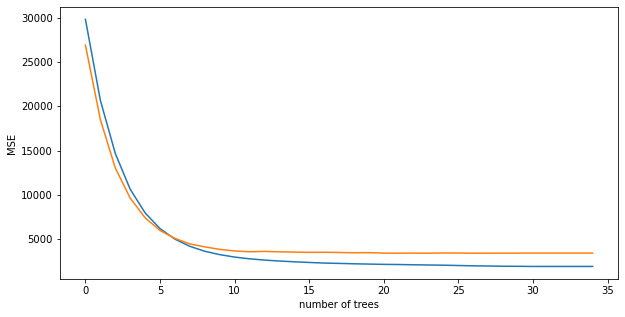

In [52]:
plt.figure(figsize=(10, 5))
plt.plot(range(len(trees)), train_errors)
plt.plot(range(len(trees)), test_errors)
plt.xlabel('number of trees')
plt.ylabel('MSE')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

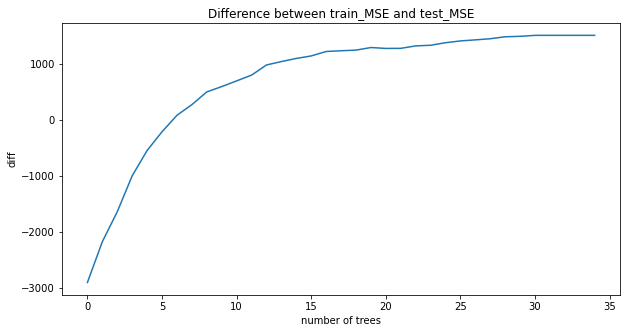

In [53]:
diff = []
for i in range(len(test_errors)):
    diff.append(test_errors[i] - train_errors[i])
    
plt.figure(figsize=(10, 5))
plt.plot(range(len(test_errors)), diff)
plt.title('Difference between train_MSE and test_MSE')
plt.xlabel('number of trees')
plt.ylabel('diff')
plt.show

***
**Итоги градиентного бустинга на кастомных деревьях:**
- Лучшее test_mse - 3426.9545
- Время работы алгоритма - 9.64 s
- Разница между train/test - 1200   
  
**Выводы:**  
  
Разница между трейном и тестом у нас +- такая же, как и у обычного бустинга  
Итоговая тестовая MSE примерно на 100 больше, чем у обычного бустинга  
Алгоритм отработал почти в 100 раз медленнее, из за моих питоновских циклов в функции предикта для деревьев (не успеваю довести это дело до ума, горит дедлайн сдачи д/з :(  )
***